# Abalone age prediction

#### Problem description:
    
Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.

#### Dataset information:

This dataset has only physical measures of abalones. We have 8 features and one target. This dataset has been preprocessed and has no missing values. Typically this dataset is used as a benchmark.

#### Goal: 

Predict physical age of Abalone. Explore possible associations between physical features and age.

***

We start by importing the data using UCI Ivrine machine learning repository API.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo
import plotly.express as px
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os
os.environ['OUTDATED_IGNORE'] = '1'

In [6]:
abalone = fetch_ucirepo(id=1)

X = abalone.data.features
y = abalone.data.targets

abalone.variables

name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7            after being dried  grams             no  
8  +1.5 gives the age in years   None             no

***
Here we convert it into a dataframe for ease of use

In [8]:
df = pd.DataFrame(X)
df['rings'] = y

In [9]:
df.describe()

Length     Diameter       Height  Whole_weight  Shucked_weight  \
count  4177.000000  4177.000000  4177.000000   4177.000000     4177.000000   
mean      0.523992     0.407881     0.139516      0.828742        0.359367   
std       0.120093     0.099240     0.041827      0.490389        0.221963   
min       0.075000     0.055000     0.000000      0.002000        0.001000   
25%       0.450000     0.350000     0.115000      0.441500        0.186000   
50%       0.545000     0.425000     0.140000      0.799500        0.336000   
75%       0.615000     0.480000     0.165000      1.153000        0.502000   
max       0.815000     0.650000     1.130000      2.825500        1.488000   

       Viscera_weight  Shell_weight        rings  
count     4177.000000   4177.000000  4177.000000  
mean         0.180594      0.238831     9.933684  
std          0.109614      0.139203     3.224169  
min          0.000500      0.001500     1.000000  
25%          0.093500      0.130000     8.000000  
50%          0.171000      0.234000     9.000000  
75%          0.253000      0.329000    11.000000  
max          0.760000      1.005000    29.000000

- For all features we notice the mean and median are close so we expect there distributions to be somewhat symmetric.
- We notice that max values for height and weights deviate too much from the 75th quartiles so we expect to see outliers.
- Also, Their seems to be an outlier in rings.

Text(0.5, 0.98, 'Number of samples of abalone in each Sex')

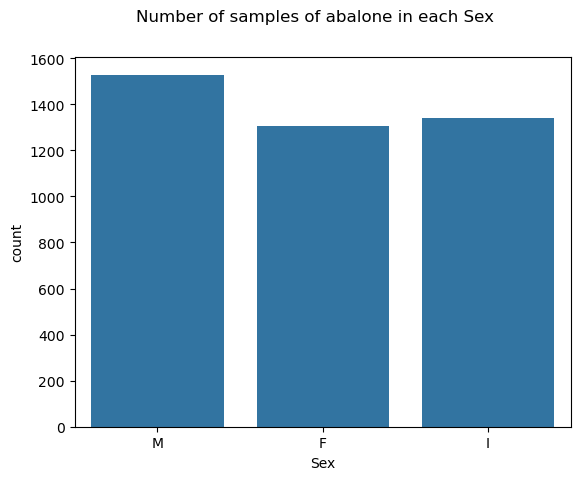

In [11]:
cnt_plot = sns.countplot(x='Sex', data=df)
cnt_plot.figure.suptitle('Number of samples of abalone in each Sex')

We have nearly equal number of samples of abalones in each sex

Now lets tak a look at the features Distributions

Text(0.5, 0.98, 'Distributions of the 8 features')

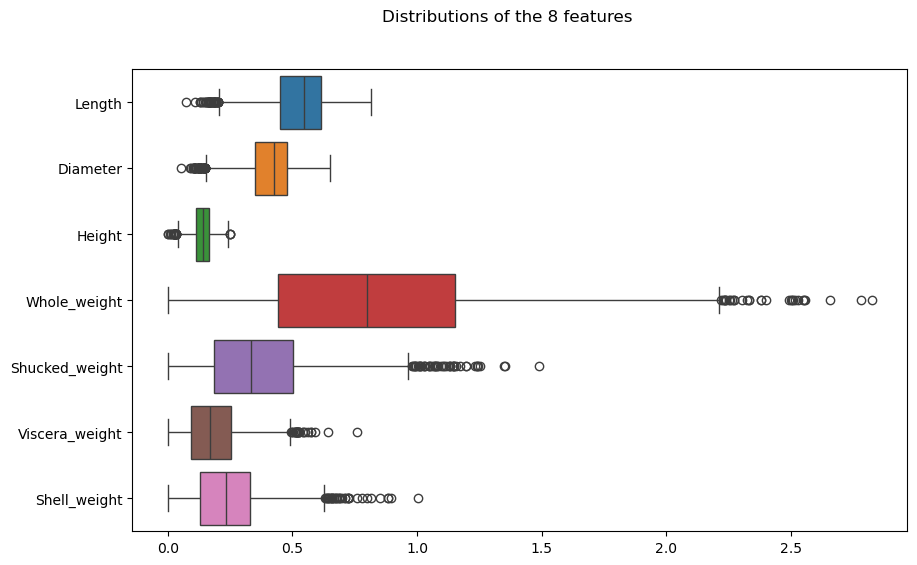

In [99]:
box_plot =sns.boxplot(df.drop(['Sex','rings'],axis=1), orient = "h")
box_plot.figure.set_size_inches(10,6)
box_plot.figure.suptitle('Distributions of the 8 features')

Here we notice two outliers in height that are visually clear.

Let's inspect the distribution of the target

Text(0, 0.5, 'Frequency')

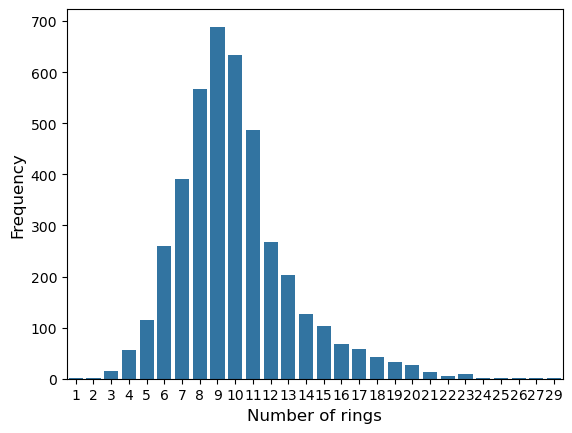

In [15]:
count_plot = sns.countplot(x='rings', data=df)

count_plot.set_xlabel('Number of rings', fontsize = 12)
count_plot.set_ylabel('Frequency', fontsize = 12)

We notice the right tailed distribution with what might be an outlier at 29 rings since there is no in between

Let's explore the correlation between the features. This is easy and feasible since we have a total of 9 columns. We will use a heatmap to visulize it easily.  
*Note:* Due to the discrete nature of number of rings it is better to use spearman's correlation because it depends on rank and can capture monotonic relationships(Which we have here) while being robust to outliers 

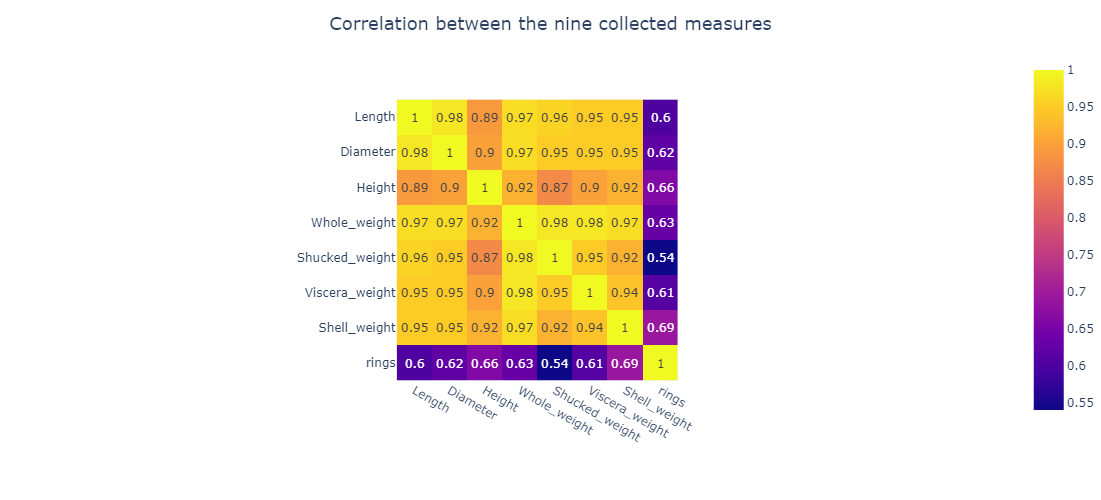

In [17]:
#Calculating the correlation matrix
correlation_matrix = round(df.drop('Sex',axis = 1).corr(method='spearman') , 2)
#Initializing the heatmap figure with the correlation matrix data
fig = px.imshow(correlation_matrix, text_auto = True , width = 500, height= 500)
# Updating the title and its position and size. Also, we change the colorbar poision to hug the heatmap more
fig.update_layout(title = 'Correlation between the nine collected measures', title_x = .5, title_font_size = 18,
                 coloraxis_colorbar = dict(yanchor = "middle", xanchor = 'right', x = 1, xref=  'container'))
fig.show()

There are very significant amounts of autocorrelation. We also notice the weak correlation between the features and the target.

While this is problmatic this means that these features don't have strong linear relationship with the target. So, we need to explore non-linear relationships.
***
We will drop the two oultiers we found above. While it might be worth ivestigating what they are it is not of interest here.

In [19]:
df = df.drop(index=df.nlargest(2,'Height').index)

One more thing I want to check is if there is distinction between abalones according to sex.

We have males, females, and infants. Naturally infants should have less rings because they are younger so let's verify this.

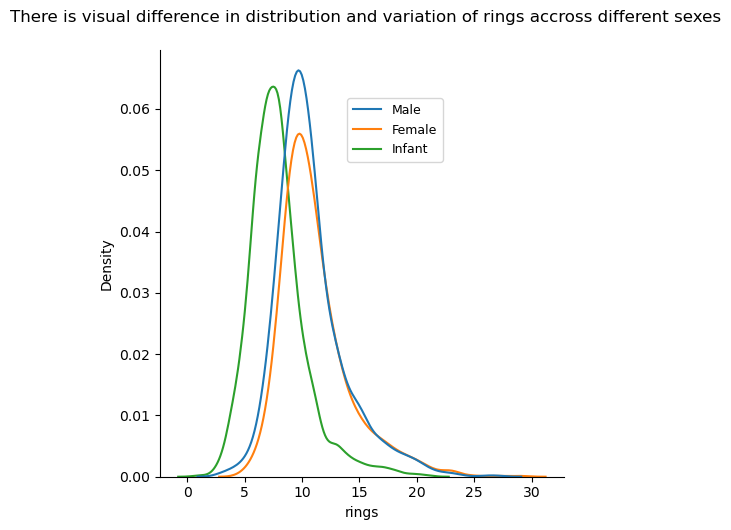

In [21]:
displot = sns.displot(data = df, x='rings' , hue = "Sex", kind = "kde")

displot.figure.suptitle('There is visual difference in distribution and variation of rings accross different sexes',
                        y = 1.05, x = .5)

displot._legend.set_bbox_to_anchor((.8, .8))  # Adjust the values to position the legend
displot._legend.set_title('') # remove the legend's title
displot._legend.set_frame_on(True) #draw a frame to contain the legend. This is visually clearer here

# we take the texts array that are displayed in the legend and change them and their size
for t, l in zip(displot._legend.texts, ['Male', 'Female','Infant']):
    t.set_text(l)
    t.set_fontsize(9)

Different Sexes have different distributions. It requires domain knolowedge to be certain about how to interpret this. 

* But we can say that our sample have more younger males.
* Also we notice the left tail of infants which blurs the line deciding wether this is a male or a female.
* Visually we see different means accross different sexes so we might want to statistically confirm this. But a normal anova test wouldn't be right since we notice the difference in variation among groups so we will resort to a type of ANOVA that is robust in this case.

***
Let't visually inspect the relationship the number of rings and the shell weight since it has the highest correlation.

We will only plot the shell weight because all features are highly correlated so we can only plot it and safely assume that other features will look the same

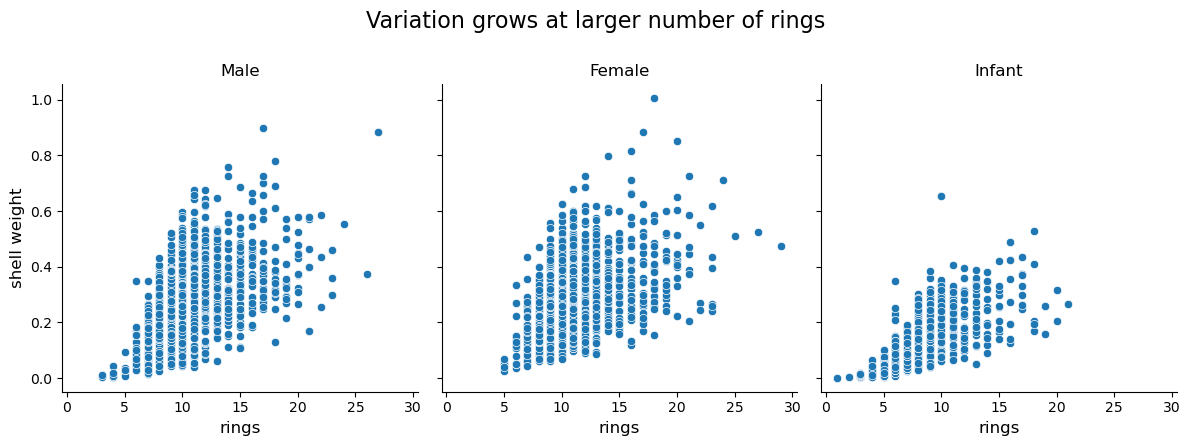

In [24]:
#Create a grid object first
g = sns.FacetGrid(df, col="Sex", height=4, aspect=1,)
#Map the plots into the grids
g.map(sns.scatterplot, "rings", "Shell_weight")

# we turn the axes into an array of axes instead of a matrix and then zip it with the respective title 
for ax, title in zip(g.axes.flat, ['Male', "Female", "Infant"]):
    ax.set_title(title)
# Adjusting the title, its size, and location
g.figure.suptitle('Variation grows at larger number of rings',fontsize=16,y=1.1)
#Setting the axis labels
for ax in g.axes.flat:
    ax.set_xlabel("rings", fontsize=12)
    ax.set_ylabel("shell weight", fontsize=12)
    #ax.set_xscale('log')

We conclude that for any age or number of rings shell weights will vary too much.

Also, between the age of 6 and 20 the variation in shell weight increases. The mean is also increasing but this is natural.

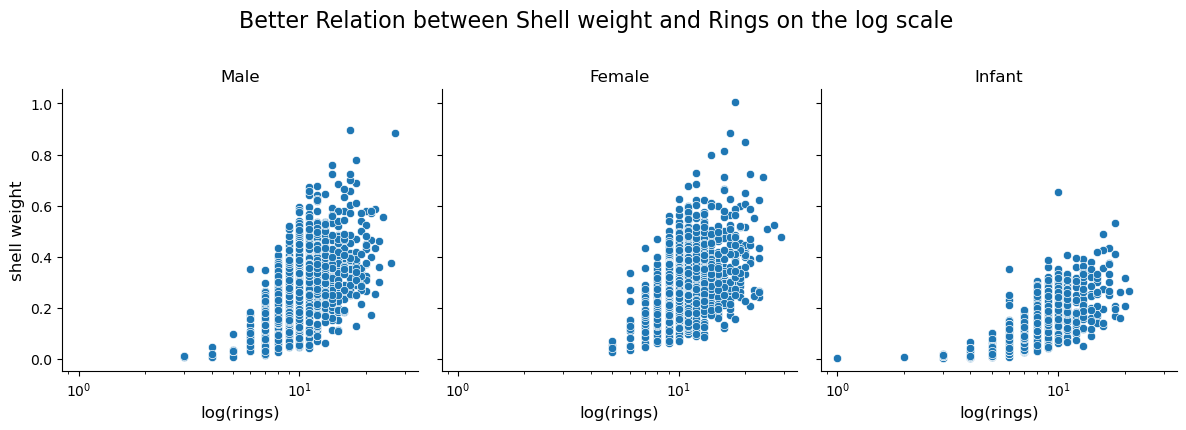

In [26]:
# Create a grid object first
g = sns.FacetGrid(df, col="Sex", height=4, aspect=1)
# Map the plots into the grids
g.map(sns.scatterplot, "rings", "Shell_weight")

# Clearer names
for ax, title in zip(g.axes.flat, ['Male', "Female", "Infant"]):
    ax.set_title(title)
# We set a figure subtitle and adjust its size and height from the axes.
g.figure.suptitle('Better Relation between Shell weight and Rings on the log scale',fontsize = 16, y = 1.05)
# Here we adjust the subplots to leave some space for the title.
plt.subplots_adjust(top=.85)
# we generally fiddle with the numbers until we reach something that looks good
# Setting the axis labels
for ax in g.axes.flat:
    ax.set_xlabel("log(rings)", fontsize=12)
    ax.set_ylabel("shell weight", fontsize=12)
    # Exploring the log scale
    ax.set_xscale('log')

Here we just tried the log scale to see if we can have a better relationship with the featrues and it turns out it's better especially with infants
***
Earlier we pointed out the possibility of statistical difference of average number of rings among different sex.

Here we test this hypothesis using Welch's ANOVA

In [28]:
import pingouin as pg
result = pg.welch_anova(dv='rings', between='Sex', data=df)
result

Source  ddof1        ddof2           F          p-unc       np2
0    Sex      2  2741.846642  570.857046  5.423709e-208  0.193234

Welch's ANOVA result shows that the difference between the average number of rings among different sexes is statistically significant.

Gameshowell is a post-hoc test used after Welch's ANOVA to test differences among different comination of groups to point out which groups have significantly different mean.

In [30]:
post_hoc = pg.pairwise_gameshowell(dv='rings', between='Sex', data=df)
round(post_hoc,3)

A  B  mean(A)  mean(B)   diff     se       T        df   pval  hedges
0  F  I   11.132    7.890  3.241  0.110  29.492  2507.137  0.000   1.149
1  F  M   11.132   10.706  0.426  0.116   3.681  2740.694  0.001   0.139
2  I  M    7.890   10.706 -2.815  0.103 -27.216  2857.657  0.000  -1.006

All groups have statistically significant difference between means. One thing to note though, The p-value for female-Male ANOVA might not be that significant in this setting but this needs a field expert opinion.

# Modeling

From previous trials it turns out that different models will not perform differently. So will use a support vector regressor with rbf kernel and some flexibility to capture the slight non-linearity in the data. The default regularization we are using turns out to be best because if it gets too high it starts punishing the weights too much because of the auto correlation.

The only preprocessing step we will need is to encode the Sex column to have 3 different columns for the categories

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error 

#Encoding the sex column into its categories
df_encoded = pd.get_dummies(df, columns=['Sex'],drop_first= True)

#Splitting the data for training and testing.
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('rings',axis=1), np.log(df['rings']),
                                                    random_state = 42 , test_size=0.2)

In [34]:
import statsmodels.api as sms
import statsmodels.formula.api as smf


lr = smf.ols("np.log(rings) ~ C(Sex)+"+ '+'.join(col for col in df.drop(['Sex','rings'],axis=1).columns), data=df).fit()

In [35]:
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(rings)   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     713.3
Date:                Sat, 10 Aug 2024   Prob (F-statistic):               0.00
Time:                        17:32:29   Log-Likelihood:                 785.96
No. Observations:                4175   AIC:                            -1552.
Df Residuals:                    4165   BIC:                            -1489.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.3049      0.027     48.

### What does this report tells us?
* R-squared of 0.606 indicates that our model can explain 60.6% of the variance in our data
* The significant F-statistic tells us that we have at least one variable that doesn't have a slope of 0. i.e. it can be used to predict the target.
* The t-statistics we got indicate that when all variables are used together only the Male variable's coeffecient could have been zero and it might be just be non-zero due to pure chance.
* Omnibus and Jarque-Bera statistics test for normality of residuals and both indicate that the residuals deviate significantly from the normal distribution. This is to be checked through visually.
* Skewness and Kurtosis describe the distribution of the residuals and are used for in JB and Omnibus tests.
* Durbin-Watson tests for Autocorrelation among the residuals. a value of 1.387 indicates positive autocorrelation. This is to be expected since Condition number is 138 indecating strong multicollinearity. This was noted earlier after observing the correlation matrix.


Most important of all, Since we have highly correlated variables then its useless to do t-tests. In fact it's good we could even pull out an estimation.

### Now let's plot some plots to help us understand why our model's performance and the nature of our data

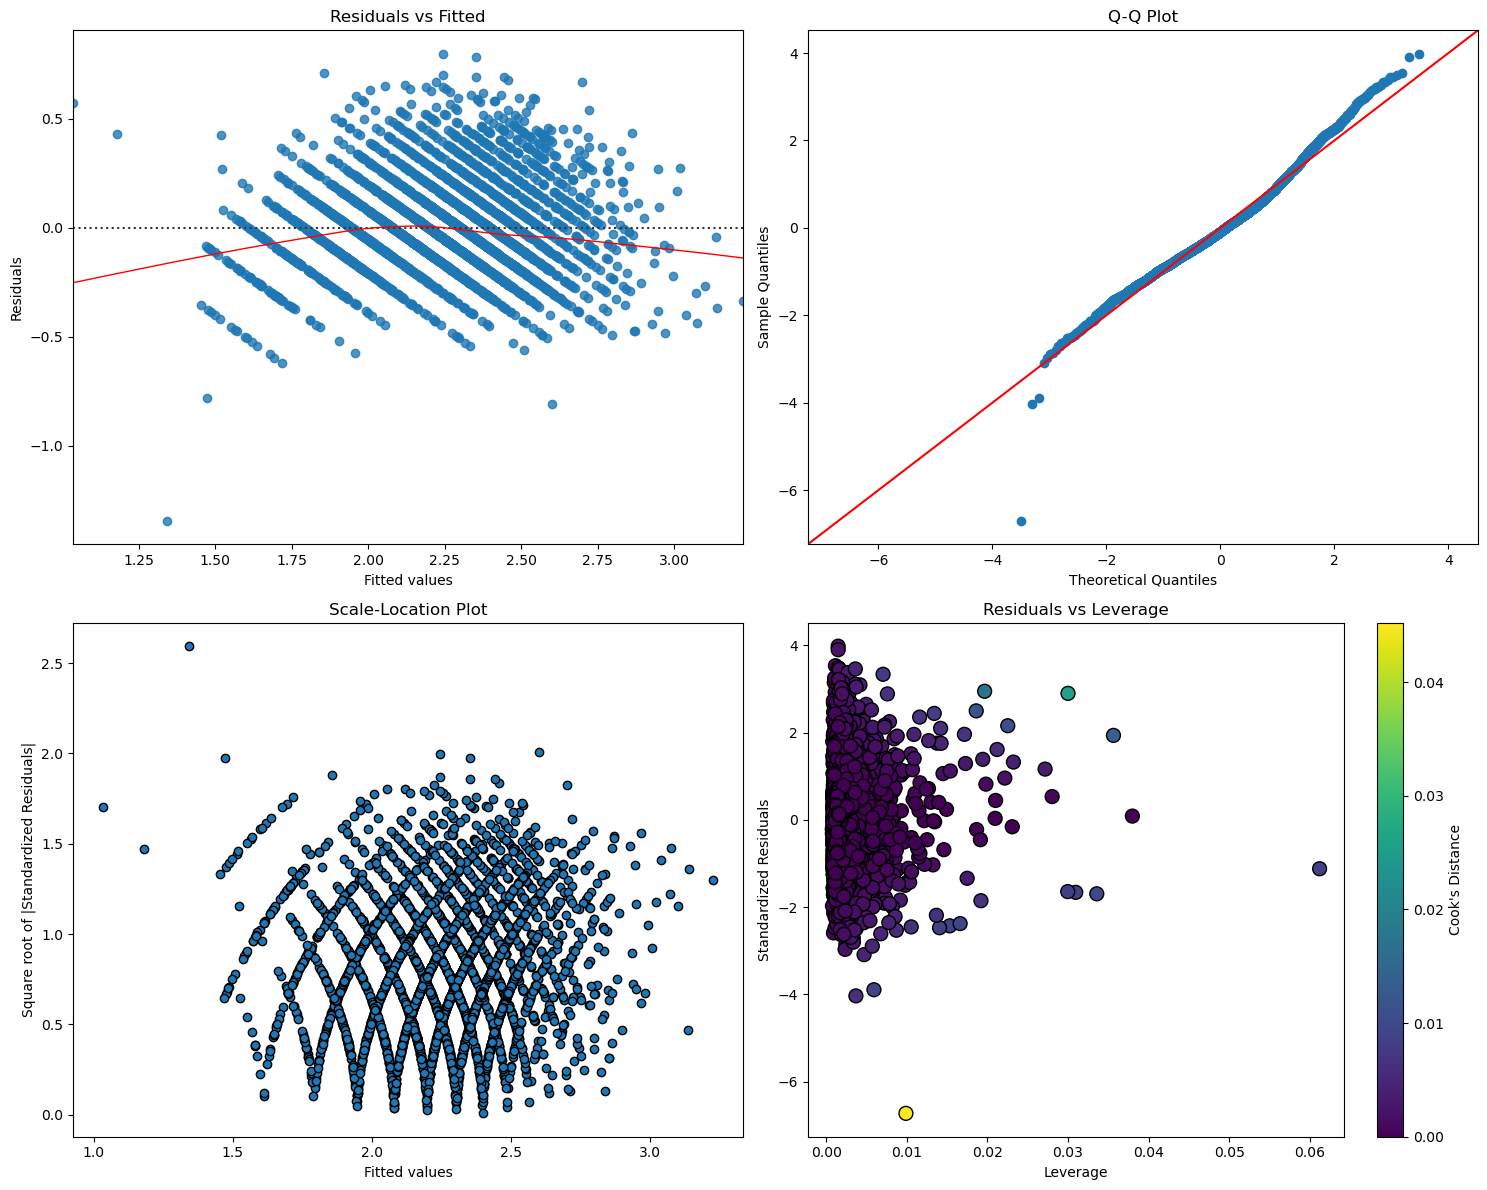

In [39]:
# Extract the fitted values 
fitted = lr.fittedvalues
# Get the residuals
residuals = lr.resid
standardized_residuals = lr.get_influence().resid_studentized_internal
# Leverage is how far from the mean are the predictor values used to predict this value
leverage = lr.get_influence().hat_matrix_diag
cooks_d = lr.get_influence().cooks_distance[0]

# Create a 2x2 grid to put the four plots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Residuals vs Fitted Plot
sns.residplot(x=fitted, y=residuals, lowess=True, ax=axs[0, 0], line_kws={'color': 'red', 'lw': 1})
axs[0, 0].set_xlabel('Fitted values')
axs[0, 0].set_ylabel('Residuals')
axs[0, 0].set_title('Residuals vs Fitted')

# Q-Q plot shows the theoritical quantiles of a normal distribution and we plot our residual's against it.
sms.qqplot(residuals, line='45', fit=True, ax=axs[0, 1])
axs[0, 1].set_title('Q-Q Plot')


sqrt_abs_standardized_residuals = np.sqrt(np.abs(standardized_residuals))
axs[1, 0].scatter(fitted, sqrt_abs_standardized_residuals, edgecolor='k')
axs[1, 0].set_xlabel('Fitted values')
axs[1, 0].set_ylabel('Square root of |Standardized Residuals|')
axs[1, 0].set_title('Scale-Location Plot')


axs[1, 1].scatter(leverage, standardized_residuals, c=cooks_d, cmap='viridis', edgecolor='k', s=100)
axs[1, 1].set_xlabel('Leverage')
axs[1, 1].set_ylabel('Standardized Residuals')
axs[1, 1].set_title('Residuals vs Leverage')
plt.colorbar(axs[1, 1].collections[0], ax=axs[1, 1], label="Cook's Distance")

# Adjust layout
plt.tight_layout()
plt.show()

* The residual and fitted values plot shows a non-constant variance. There seems to be a slight bias in the model leading to underestimating larger number of rings. But the bias doesn't seem significant rather we should try to account for the variance.
* The theoritical quantiles plot shows that we have significant deviation from normality at the right tail.
* Scale-Location plot shows a clear weird pattern. This further reinforces the abscence of homoscedasticity.
* Residuals vs Leverage plot shows influential points. Despite the colour this point will not be very significant as it has very little leverage.

We try the Support vector regression model. We expect it to also suffer due to high correlation but it doesn't suffer as much as linear regression.  
Also, we will be using hyperopt library to try and find the hyperparameters that yield the best model.

In [42]:
from bayes_opt import BayesianOptimization
def svr_evaluate_svr(C_svr, epsilon_svr, gamma_svr, kernel_svr):
    # Convert kernel to appropriate type
    kernel_svr = 'linear' if kernel_svr < 0.5 else 'rbf'
    
    # Create and fit the SVR model
    model_svr = SVR(C=C_svr, epsilon=epsilon_svr, kernel=kernel_svr, gamma=gamma_svr)
    model_svr.fit(X_train, y_train)
    
    # Predict and calculate MSE
    preds_svr = model_svr.predict(X_test)
    mse_svr = mean_squared_error(df['rings'].loc[y_test.index], np.round(np.exp(model_svr.predict(X_test))))
    
    return -mse_svr  # We minimize the negative MSE to maximize the original MSE

# Define the parameter bounds for Bayesian Optimization
pbounds_svr = {
    'C_svr': (50, 70),  # Regularization parameter
    'epsilon_svr': (0.09, 0.12),  # Epsilon in the epsilon-SVR model
    'gamma_svr': (0.2, 0.25),
    'kernel_svr': (0, 1)  # 0 for 'linear', 1 for 'rbf'
}

# Initialize Bayesian Optimization
optimizer_svr = BayesianOptimization(
    f=svr_evaluate_svr,
    pbounds=pbounds_svr,
    verbose=2,
    random_state=42
)

# Perform Bayesian Optimization
optimizer_svr.maximize(init_points=10, n_iter=100)

|   iter    |  target   |   C_svr   | epsilo... | gamma_svr | kernel... |
-------------------------------------------------------------------------
| 1         | -4.369    | 57.49     | 0.1185    | 0.2366    | 0.5987    |
| 2         | -4.291    | 53.12     | 0.09468   | 0.2029    | 0.8662    |
| 3         | -4.287    | 62.02     | 0.1112    | 0.201     | 0.9699    |
| 4         | -4.944    | 66.65     | 0.09637   | 0.2091    | 0.1834    |
| 5         | -4.862    | 56.08     | 0.1057    | 0.2216    | 0.2912    |
| 6         | -4.926    | 62.24     | 0.09418   | 0.2146    | 0.3664    |
| 7         | -4.241    | 59.12     | 0.1136    | 0.21      | 0.5142    |
| 8         | -4.916    | 61.85     | 0.09139   | 0.2304    | 0.1705    |
| 9         | -4.358    | 51.3      | 0.1185    | 0.2483    | 0.8084    |
| 10        | -4.933    | 56.09     | 0.09293   | 0.2342    | 0.4402    |
| 11        | -4.323    | 58.5      | 0.1156    | 0.2202    | 0.5467    |
| 12        | -4.316    | 52.29     | 

In [43]:
# Extract the best parameters
best_params_svr = optimizer_svr.max['params']
best_params_svr['C_svr'] = int(best_params_svr['C_svr'])
best_params_svr['epsilon_svr'] = best_params_svr['epsilon_svr']
best_params_svr['kernel_svr'] = 'linear' if best_params_svr['kernel_svr'] < 0.5 else 'rbf'

print(f"Best Parameters: {best_params_svr}")

# Train and evaluate the final model with the best parameters
model_svr = SVR(C=best_params_svr['C_svr'],
                epsilon=best_params_svr['epsilon_svr'],
                kernel=best_params_svr['kernel_svr'], 
                gamma=best_params_svr['gamma_svr'])
model_svr.fit(X_train, y_train)
preds_svr = model_svr.predict(X_test)
rmse_svr = np.sqrt(mean_squared_error(df['rings'].loc[y_test.index], np.ceil(np.exp(model_svr.predict(X_test)))))
print(f"Final RMSE: {rmse_svr}")

Best Parameters: {'C_svr': 58, 'epsilon_svr': 0.1138048452073855, 'gamma_svr': 0.21348279418539506, 'kernel_svr': 'rbf'}
Final RMSE: 2.0858806781771615


In [44]:
print(r2_score(df['rings'].loc[y_test.index], np.round(np.exp(model_svr.predict(X_test)))))

0.6018796144093448


We see that our model was able to explain about 60% of the variance. This number is great if we think about the kind of data we have
To interpret the mean squared error we can say that on average our model's predictions of the number of rings is far by about 2 rings more or less. We can compute confidence intervals assuming normality of errors but we will have to test that.

Here we will try using the xgboost model as it can handle the high number of features well. We will directly use bayesian optimzation to find the optimal parameters and then get the best model.

In [136]:
import xgboost as xgb
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from sklearn.metrics import mean_squared_error
import numpy as np



# Capture the output in a scrollable div
output = io.StringIO()
with redirect_stdout(output):
    # Define the search space
    def xgb_evaluate(max_depth, learning_rate, n_estimators, gamma, min_child_weight, subsample, colsample_bytree):
        params = {
            'max_depth': int(max_depth),
            'learning_rate': learning_rate,
            'n_estimators': int(n_estimators),
            'gamma': gamma,
            'min_child_weight': min_child_weight,
            'subsample': subsample,
            'colsample_bytree': colsample_bytree,
            'device': 'cuda'  # Use GPU
        }
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, np.round(np.exp(preds)))
        return -mse # The bayesian optimization algorithm maximizes the function so we have to reverse it

    # Define the parameter bounds
    pbounds = {
        'max_depth': (20, 25),
        'learning_rate': (0.1, 0.12),
        'n_estimators': (400, 450),
        'gamma': (0.1, 0.15),
        'min_child_weight': (9, 11),
        'subsample': (0.6, 0.67),
        'colsample_bytree': (0.7, 0.8)
    }

    # Perform Bayesian optimization
    optimizer = BayesianOptimization(
        f=xgb_evaluate,
        pbounds=pbounds
    )

    optimizer.maximize(init_points=10, n_iter=1)


Now we extract the best parameters and use them to build the model and evaluate it

In [97]:
# Extract the best parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
print("Best Parameters found",best_params)


# Train the final model with the best parameters
model = xgb.XGBRegressor(**best_params,device= 'cuda')
model.fit(X_train, y_train)
preds = model.predict(X_test)
mse = mean_squared_error( df['rings'].loc[y_test.index] , np.round(np.exp(model.predict(X_test))))
print(f"\nMSE: {mse}")
print(f"RMSE: {np.sqrt(mse)}")

Best Parameters found {'colsample_bytree': 0.7023061026836672, 'gamma': 0.10899202939146396, 'learning_rate': 0.10274761227752033, 'max_depth': 23, 'min_child_weight': 9.278865095598196, 'n_estimators': 423, 'subsample': 0.6528212026654843}

MSE: 4.302994011976048
RMSE: 2.0743659301039554


Not so bad but not better.  
Now we try the Lasso and ridge models with cross validation

In [52]:
from sklearn.linear_model import  LassoCV, RidgeCV

In [53]:
ls = LassoCV(cv=5)
lR = RidgeCV(cv=5)

ls.fit(X_train,y_train)
lR.fit(X_train,y_train)

ls_mse = mean_squared_error( df['rings'].loc[y_test.index] , np.round(np.exp(ls.predict(X_test))))
lr_mse = mean_squared_error( df['rings'].loc[y_test.index] , np.round(np.exp(lR.predict(X_test))))

print("Lasso Mean squared Error (test):",ls_mse)
print("Ridge Mean squared Error (test):", lr_mse)

Lasso Mean squared Error (test): 4.879041916167664
Ridge Mean squared Error (test): 4.853892215568862


Comparing to what we get using SVR and XGB we got a much worse score.  
Now we also look at Random Forest Regression

In [55]:
from sklearn.ensemble import RandomForestRegressor

In [56]:
# Define the model
def rf_evaluate_rf(n_estimators_rf, max_depth_rf, min_samples_split_rf, min_samples_leaf_rf, max_features_rf):
    # Create and fit the RandomForestRegressor model
    model_rf = RandomForestRegressor(
        n_estimators=int(n_estimators_rf),
        max_depth=int(max_depth_rf),
        min_samples_split=int(min_samples_split_rf),
        min_samples_leaf=int(min_samples_leaf_rf),
        max_features=max_features_rf,
        random_state=42
    )
    model_rf.fit(X_train, y_train)
    
    # Predict and calculate RMSE
    mse_rf = mean_squared_error( df['rings'].loc[y_test.index] , np.round(np.exp(model_rf.predict(X_test))))
    
    return -mse_rf  # We minimize the negative RMSE to maximize the original RMSE

# Define the parameter bounds for Bayesian Optimization
pbounds_rf = {
    'n_estimators_rf': (10, 500),
    'max_depth_rf': (5, 30),
    'min_samples_split_rf': (2, 20),
    'min_samples_leaf_rf': (1, 10),
    'max_features_rf': (0.1, 1.0)
}

# Initialize Bayesian Optimization
optimizer_rf = BayesianOptimization(
    f=rf_evaluate_rf,
    pbounds=pbounds_rf,
    verbose=2  # Print progress
)

# Perform Bayesian Optimization
optimizer_rf.maximize(init_points=10, n_iter=50)

|   iter    |  target   | max_de... | max_fe... | min_sa... | min_sa... | n_esti... |
-------------------------------------------------------------------------------------
| 1         | -4.547    | 20.93     | 0.4472    | 3.66      | 14.95     | 421.5     |
| 2         | -4.534    | 8.313     | 0.9905    | 9.07      | 17.46     | 409.5     |
| 3         | -4.517    | 19.27     | 0.7253    | 2.488     | 7.189     | 453.8     |
| 4         | -4.52     | 17.21     | 0.4504    | 2.132     | 8.102     | 240.4     |
| 5         | -4.545    | 23.08     | 0.6788    | 5.505     | 6.252     | 495.0     |
| 6         | -4.453    | 28.93     | 0.6404    | 7.961     | 17.68     | 481.2     |
| 7         | -4.671    | 7.532     | 0.6131    | 5.018     | 4.3       | 189.1     |
| 8         | -4.527    | 27.92     | 0.6779    | 4.27      | 13.63     | 269.2     |
| 9         | -4.508    | 29.47     | 0.713     | 5.088     | 7.437     | 166.2     |
| 10        | -4.638    | 23.19     | 0.3709    | 6.91

In [57]:
best_params_rf = optimizer_rf.max['params']
best_params_rf['n_estimators_rf'] = int(best_params_rf['n_estimators_rf'])
best_params_rf['max_depth_rf'] = int(best_params_rf['max_depth_rf'])
best_params_rf['min_samples_split_rf'] = int(best_params_rf['min_samples_split_rf'])
best_params_rf['min_samples_leaf_rf'] = int(best_params_rf['min_samples_leaf_rf'])

print(f"Best Parameters: {best_params_rf}")

# Train and evaluate the final model with the best parameters
model_rf = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators_rf'],
    max_depth=best_params_rf['max_depth_rf'],
    min_samples_split=best_params_rf['min_samples_split_rf'],
    min_samples_leaf=best_params_rf['min_samples_leaf_rf'],
    max_features=best_params_rf['max_features_rf'],
    random_state=42
)
model_rf.fit(X_train, y_train)
preds_rf = model_rf.predict(X_test)
mse_rf = mean_squared_error( df['rings'].loc[y_test.index] , np.round(np.exp(model_rf.predict(X_test))))
print(f'Mean Squared Error: {mse_rf}')
print(f'Root Mean Squared Error: {np.sqrt(mse_rf)}')

Best Parameters: {'max_depth_rf': 10, 'max_features_rf': 1.0, 'min_samples_leaf_rf': 3, 'min_samples_split_rf': 16, 'n_estimators_rf': 335}
Mean Squared Error: 4.445508982035928
Root Mean Squared Error: 2.1084375689206283


We get a worse score

# Conclusion

This was my best trial of using the abalone dataset. This dataset clearly don't have the best predictors but it is a popular benchmark.

I have tried before building different models for different sexes but the over all power of the models will drastically decline. But will be able to explain the infant group some what accurately. Also, you might notice a very small search space for hyperparameters, This beacause I kept iterating and updating the search space and this was the best I got.

We saw that even in abalones it in their middle age it is quite difficult to tell their age. That is why there is the cumbersome operation that has to be done. Think of humans too. Once someone hit their 20's it is hard to tell their age just by their looks but you can say they are young and same goes for those older, and this is what we are trying to do here, so we can say that this result is somewhat satisfactory. 